In [1]:
from time import time
from math import prod
import numpy as np
import matplotlib.pyplot as plt
yes = "\033[1;32m" + "\N{check mark}"  # + "\033[1;30m"
no = "\033[1;31m" + "\N{ballot x}"  # + "\033[1;30m"
from PIL import Image

# Singular Value Decomposition (SVD)

The Singular Value Decomposition (SVD) is a mathematical tool that decomposes a matrix $A$ into three components:

$$
A = U \Sigma V^T
$$

where:
- $A$: An $m \times n$ matrix.
- $U$: An $m \times m$ orthogonal matrix whose columns are the **left singular vectors** of $A$.
- $\Sigma$: An $m \times n$ diagonal matrix containing the **singular values** $\sigma_i$ of $A$ in descending order ($\sigma_1 \geq \sigma_2 \geq \dots \geq \sigma_r > 0$).
- $V^T$: The transpose of an $n \times n$ orthogonal matrix $V$, whose rows are the **right singular vectors** of $A$.

## What Does SVD Mean?

1. **Geometric Interpretation**:
   - $U$ and $V^T$ represent rotations in the input and output spaces, respectively.
   - $\Sigma$ scales the input along orthogonal directions.

2. **Singular Values ($\sigma_i$)**:
   - Measure the importance or weight of each direction in the input space.
   - Larger $\sigma_i$ contribute more to the structure of the matrix.

3. **Ranks and Compression**:
   - The number of non-zero singular values ($r$) gives the rank of the matrix $A$.
   - Truncating small singular values approximates $A$ with a lower-rank matrix.

## Properties of SVD

1. **Orthogonality**:
   - $U^T U = I_m$ and $V^T V = I_n$.
   - $U$ and $V$ are orthogonal, ensuring that the decomposition preserves the structure of $A$.

2. **Diagonal Structure**:
   - The diagonal entries of $\Sigma$ are the singular values of $A$, ordered as $\sigma_1 \geq \sigma_2 \geq \dots \geq 0$.

3. **Best Low-Rank Approximation**:
   - Truncating $\Sigma$ (keeping only the largest $k$ singular values) gives the best rank-$k$ approximation of $A$ in terms of the Frobenius norm:
     $$
     A_k = U_k \Sigma_k V_k^T
     $$
   where $U_k$, $\Sigma_k$, and $V_k^T$ are truncated versions of $U$, $\Sigma$, and $V^T$.

This reduces storage and computational requirements while retaining key features of $A$.

## Applications of SVD

1. **Data Compression**:
   - In image processing, truncating singular values reduces the data size while preserving important features.

2. **Noise Reduction**:
   - Small singular values often correspond to noise, so removing them can denoise data.

3. **Quantum Systems**:
   - SVD is fundamental for constructing tensor network representations like Matrix Product States (MPS) and Tree Tensor Networks (TTN).

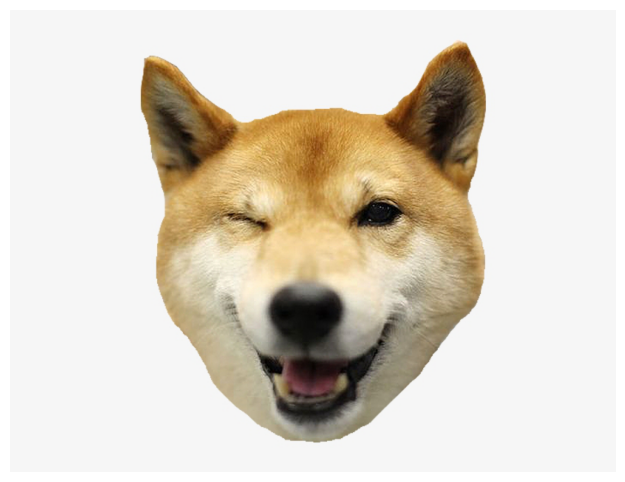

NameError: name 'truncate_singvals' is not defined

In [2]:
im_frame = Image.open("shibapng.png").convert("RGB")
image = np.array(im_frame.getdata())
x = int(np.sqrt(len(image)))
image = image.reshape(-1, 820, 3)

fig, ax = plt.subplots(figsize=(12, 6))
fig.patch.set_visible(False)
ax.axis("off")
ax.imshow(image)
plt.show()
# %%
cut_image = np.zeros_like(image)
for idx, channel in enumerate(np.moveaxis(image, -1, 0)):
    # Iterate over R, G, B channels
    # Perform SVD for each channel
    U_mat, singvals, V_mat = np.linalg.svd(channel, full_matrices=False)

    # Truncate singular values:
    # Keep only the largest singular values and vectors
    cutoff_ratio = 1e-8  # Threshold for singular value importance
    max_singular_value = singvals[0]
    k = 50  # Maximum number of singular values to keep

    # Apply the cutoff
    valid_singular_values = singvals[singvals / max_singular_value > cutoff_ratio]
    truncated_singvals = valid_singular_values[:k]
    U_mat = U_mat[:, : len(truncated_singvals)]
    V_mat = V_mat[: len(truncated_singvals), :]

    # Reconstruct the truncated channel
    channel = (U_mat * truncate_singvals) @ V_mat
    cut_image[:, :, idx] = channel

fig, ax = plt.subplots(figsize=(12, 6))
fig.patch.set_visible(False)
ax.axis("off")
ax.imshow(cut_image)
plt.show()

## The general function for the reduced density matrix

In [3]:
def get_reduced_density_matrix(psi, loc_dim, n_sites, keep_indices,
    print_rho=False):
    """
    Parameters
    ----------
    psi : ndarray
        state of the Quantum Many-Body system
    loc_dim : int
        local dimension of each single site of the QMB system
    n_sites : int
        total number of sites in the QMB system
    keep_indices (list of ints):
        Indices of the lattice sites to keep.
    print_rho : bool, optional
        If True, it prints the obtained reduced density matrix], by default False

    Returns
    -------
    ndarray
        Reduced density matrix
    """
    if not isinstance(psi, np.ndarray):
        raise TypeError(f'density_mat should be an ndarray, not a {type(psi)}')

    if not np.isscalar(loc_dim) and not isinstance(loc_dim, int):
        raise TypeError(f'loc_dim must be an SCALAR & INTEGER, not a {type(loc_dim)}')

    if not np.isscalar(n_sites) and not isinstance(n_sites, int):
        raise TypeError(f'n_sites must be an SCALAR & INTEGER, not a {type(n_sites)}')

    # Ensure psi is reshaped into a tensor with one leg per lattice site
    psi_tensor = psi.reshape(*[loc_dim for _ in range(int(n_sites))])
    # Determine the environmental indices
    all_indices = list(range(n_sites))
    env_indices = [i for i in all_indices if i not in keep_indices]
    new_order = keep_indices + env_indices
    # Rearrange the tensor to group subsystem and environment indices
    psi_tensor = np.transpose(psi_tensor, axes=new_order)
    print(f"Reordered psi_tensor shape: {psi_tensor.shape}")
    # Determine the dimensions of the subsystem and environment for the bipartition
    subsystem_dim = np.prod([loc_dim for i in keep_indices])
    env_dim = np.prod([loc_dim for i in env_indices])
    # Reshape the reordered tensor to separate subsystem from environment
    psi_partitioned = psi_tensor.reshape((subsystem_dim, env_dim))
    # Compute the reduced density matrix by tracing out the env-indices
    RDM = np.tensordot(psi_partitioned, np.conjugate(psi_partitioned), axes=([1], [1]))
    # Reshape rho to ensure it is a square matrix corresponding to the subsystem
    RDM = RDM.reshape((subsystem_dim, subsystem_dim))

    # PRINT RHO
    if print_rho:
        print('----------------------------------------------------')
        print(f'DENSITY MATRIX TRACING SITES ({str(env_indices)})')
        print('----------------------------------------------------')
        print(RDM)

    return RDM

## Entanglement of a pure quantum state between two bipartitions

Why should we care for reduced density matrices?
For many reasons (seen in the lectures). We will focus on computing the entanglement between the susbsystems, i.e. the Von Neumann Entropy:

$$
S_V = - \mathrm{Tr}(\rho\log\rho)
$$

Compute the entanglement of the following states, using the reduced density matrix formalism:

- `product` $|00\rangle$;
- `bell` $(|00\rangle+|11\rangle)/\sqrt{2}$.

Use the `log2` instead of natural logarithm since we are with qubits.

<details>
  <summary>Hint</summary>

  Not all the necessary lines are marked with ...  this time
</details>
<details>
  <summary>Solution part 7</summary>

```python
eigvl, eigvc = np.linalg.eigh(rho_A_product)
eigvl = eigvl[eigvl>0]
entanglement_product = - (eigvl*np.log2(eigvl)).sum()

...

eigvl, eigvc = np.linalg.eigh(rho_A_ghz)
eigvl = eigvl[eigvl>0]
entanglement_ghz = - (eigvl*np.log2(eigvl)).sum()
```
</details>

In [4]:
num_sites = 2
local_dim = 2

product = np.array([1, 0, 0, 0])
bell = np.array([1, 0, 0, 1])/np.sqrt(2)


rho_A_product = get_reduced_density_matrix(product, local_dim, num_sites, [1])
rho_A_bell = get_reduced_density_matrix(bell, local_dim, num_sites, [1])

eigvl, eigvc = np.linalg.eigh(rho_A_product)
eigvl = eigvl[eigvl>0]
entanglement_product = - (eigvl*np.log2(eigvl)).sum()
print(f"Entanglement of the product state: {entanglement_product}")

eigvl, eigvc = np.linalg.eigh(rho_A_bell)
eigvl = eigvl[eigvl>0]
entanglement_bell = - (eigvl*np.log2(eigvl)).sum()
print(f"Entanglement of the bell state: {entanglement_bell}")

Reordered psi_tensor shape: (2, 2)
Reordered psi_tensor shape: (2, 2)
Entanglement of the product state: -0.0
Entanglement of the bell state: 1.0


## Computing the entanglement in another way: Schmidt decomposition

We can always write a state using the Schmidt decomposition:

$$
|\psi\rangle = \sum_\alpha c_\alpha|\alpha\rangle = \sum_{\beta}^\chi c_\beta |\beta_{A}\rangle|\beta_{B}\rangle
$$

The computation of the reduced density matrix on a subsystem is then easy:

$$
\rho = |\psi\rangle\langle\psi| = \sum_\beta |c_\beta|^2 |\beta_A\rangle|\beta_B\rangle \langle\beta_A|\langle\beta_B|
$$

Computing the trace over $B$ is then strightforward:

$$
\rho_A = \mathrm{Tr}_B\rho = \sum_\gamma \langle\gamma_B|\left(\sum_\beta |c_\beta|^2 |\beta_A\rangle|\beta_B\rangle \langle\beta_A|\langle\beta_B|\right)|\gamma_B\rangle = \sum_\beta |c_\beta|^2 |\beta_A\rangle| \langle\beta_A|
$$

and the entanglement can be computed using the schmidt values squared $|c_\beta|^2$

$$
S_V = - \sum_\beta(|c_\beta|^2\log|c_\beta|^2)
$$


### Task

Compute the entanglement of the Bell state by using the Schmidt decomposition. Treat it as a tensor where you apply an svd to split site 0 and site 1
<details>
  <summary>Solution part 8</summary>

```python

bell = bell.reshape(2, 2)
beta_A, c_beta, beta_B = np.linalg.svd(bell)
entanglement = - (np.abs(c_beta)**2 * np.log2( np.abs(c_beta)**2)).sum()
```
</details>

In [5]:
bell = np.array([1, 0, 0, 1])/np.sqrt(2)

bell = bell.reshape(...)

beta_A, c_beta, beta_B = np.linalg.svd(bell)

entanglement_bell = - ...
print(f"Entanglement of the ghz state: {entanglement_bell}")

TypeError: expected a sequence of integers or a single integer, got 'Ellipsis'